In [1]:
# LIBRARIES

import pandas as pd
from pandas.plotting import scatter_matrix
import datetime
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error, get_scorer_names
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.svm import SVR

In [2]:
# DATASET

df = pd.read_csv('E5147249_Roberts_Jennifer_DATASET.csv')

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
# DATA TYPES

#df.dtypes
# Date column is an object, change to datetime

df['date'] = pd.to_datetime(df['date'])
print(f"Date range {df['date'].min()} to {df['date'].max()}")

df.columns = df.columns.str.lower()

#df.head()


Date range 2016-01-11 17:00:00 to 2016-05-27 18:00:00


In [4]:
# BASIC CHECKS

df = df.replace('', np.nan)
print(f"{df.isnull().sum().sum()} blanks or NaNs")
print(f"{df.duplicated().sum()} duplicate rows")
print(f"{df.columns.duplicated().sum()} duplicate columns")
print(f"{np.where(df.nunique() == 1,1,0).sum()} single-value columns")

0 blanks or NaNs
0 duplicate rows
0 duplicate columns
0 single-value columns


In [5]:
df.describe()

,date,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,...,t9,rh_9,t_out,press_mm_hg,rh_out,windspeed,visibility,tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,2016-03-20 05:30:00,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
min,2016-01-11 17:00:00,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,2016-02-14 23:15:00,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,2016-03-20 05:30:00,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,2016-04-23 11:45:00,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,2016-05-27 18:00:00,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634


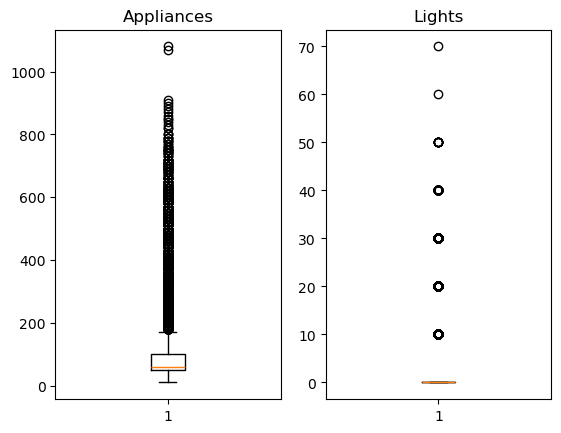

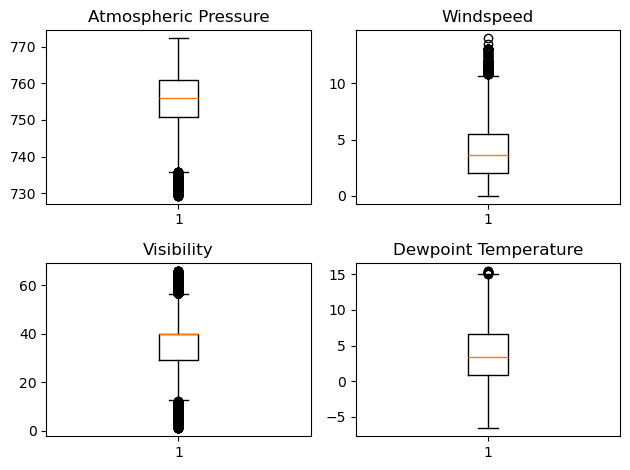

In [6]:
# OUTLIERS

fig,(ax1, ax2) = plt.subplots(1,2)
ax1.boxplot(df['appliances'])
ax1.set_title('Appliances')
ax2.boxplot(df['lights'])
ax2.set_title('Lights')

fig, axs = plt.subplots(2,2)
axs[0,0].boxplot(df['press_mm_hg'])
axs[0,0].set_title('Atmospheric Pressure')
axs[0,1].boxplot(df['windspeed'])
axs[0,1].set_title('Windspeed')
axs[1,0].boxplot(df['visibility'])
axs[1,0].set_title('Visibility')
axs[1,1].boxplot(df['tdewpoint'])
axs[1,1].set_title('Dewpoint Temperature')
plt.tight_layout()

<Axes: >

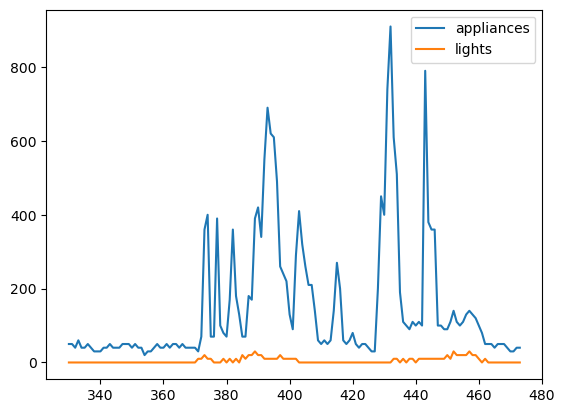

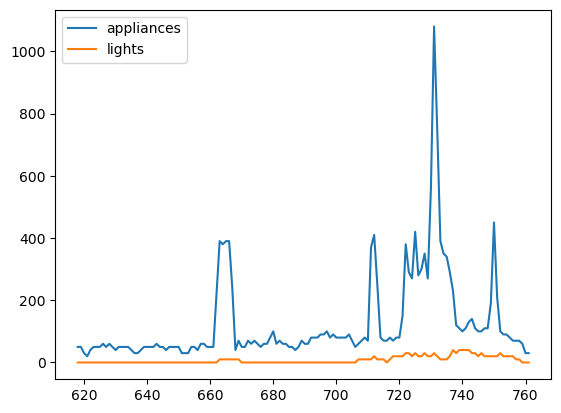

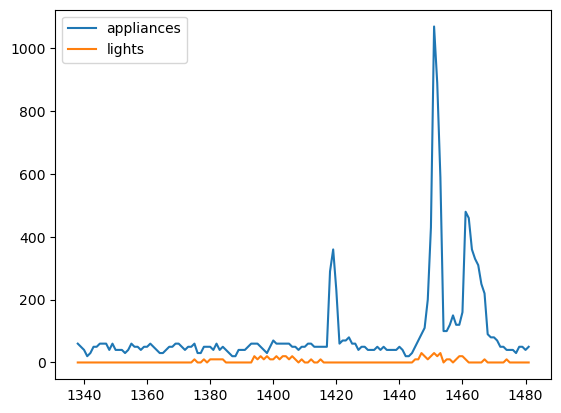

In [7]:
# Outliers in appliances

df.loc[df['appliances'] > 900]

# Seems odd that appliances should be so high without any lights, at what should have been around sunset. Thursday
# 16th is a Saturday, 21st a Thursday. Given that the three are close together, they may have had guests?

df.loc[df['date'].dt.strftime('%Y-%m-%d') == '2016-01-14'][['appliances','lights']].plot.line()

df.loc[df['date'].dt.strftime('%Y-%m-%d') == '2016-01-16'][['appliances', 'lights']].plot.line()

df.loc[df['date'].dt.strftime('%Y-%m-%d') == '2016-01-21'][['appliances', 'lights']].plot.line()

# These could be errors, but they could also be correct. If I were the researcher, I would check with the family.

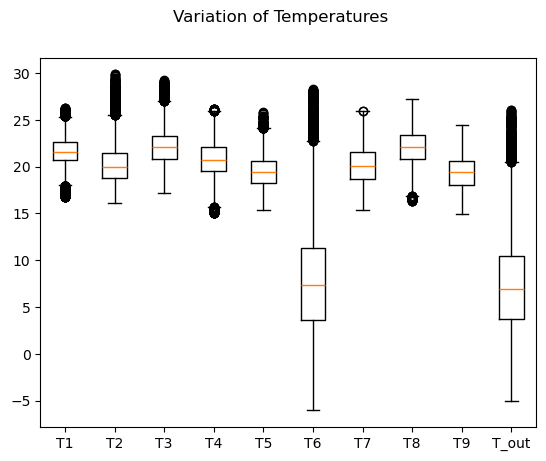

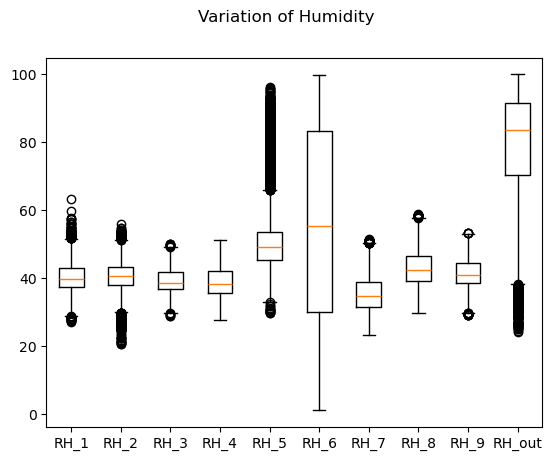

In [8]:
# OUTLIERS

# Temps (T6 and T_out are outside)
df_temp = df[['t1', 't2', 't3', 't4', 't5','t6','t7', 't8', 't9', 't_out']]
fig,ax = plt.subplots()
fig.suptitle('Variation of Temperatures')
ax.boxplot(df_temp)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], labels=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out'])
plt.show()
# All within a reasonable range

# Humidity
df_hum = df[['rh_1','rh_2', 'rh_3','rh_4','rh_5','rh_6','rh_7','rh_8','rh_9','rh_out']]
fig, ax = plt.subplots()
fig.suptitle('Variation of Humidity')
ax.boxplot(df_hum)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], labels=['RH_1','RH_2', 'RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9','RH_out'])
plt.show()
# 5 is the bathroom, hence the large variation

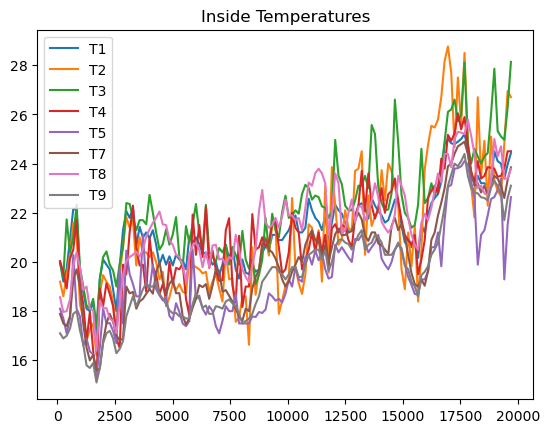

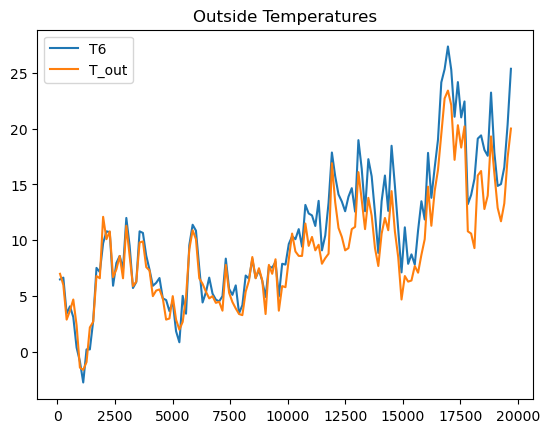

<Axes: title={'center': 'Difference in Outside Temperatures'}>

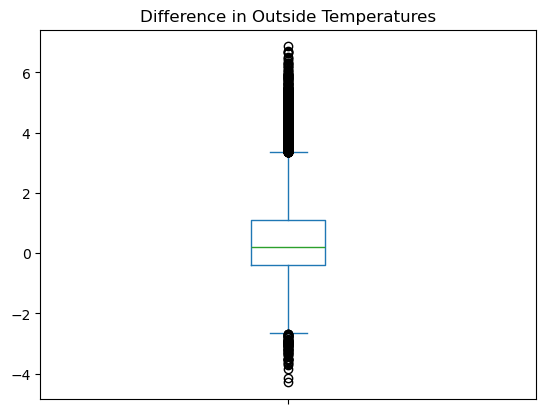

In [9]:
# TEMPS AT NOON

# Inside
df_temp_noon_ins = df[['t1', 't2', 't3', 't4', 't5','t7', 't8', 't9']].loc[df['date'].dt.time == pd.Timestamp('12:00:00').time()]
fig, ax = plt.subplots()
ax.plot(df_temp_noon_ins)
plt.legend(labels=['T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'T9'])
plt.title('Inside Temperatures')
plt.show()

# Outside
df_temp_noon_out = df[['t6', 't_out']].loc[df['date'].dt.time == pd.Timestamp('12:00:00').time()]
fig,ax = plt.subplots()
ax.plot(df_temp_noon_out)
plt.legend(labels = ['T6', 'T_out'])
plt.title('Outside Temperatures')
plt.show()
# Some differences between the two measurements, but far too correlated to use both. Maybe mean?

(df_temp['t6'] - df_temp['t_out']).plot(kind = 'box', title = 'Difference in Outside Temperatures')

In [10]:
# COMPUTED COLUMNS
# Experiments to find the best measures for time, temp and humidity.

# Clocks went forward one hour Sunday 27 March, so an hour disappeared.

# Date and time
df['week_of_year'] = df['date'].apply(lambda x: x.week)
df['day_of_week'] = df['date'].apply(lambda x: x.day_of_week)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['nsm'] = df['date'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second) # Number of seconds from midnight. From the original paper.
df['nmm'] = df['date'].apply(lambda x: x.hour * 60 + x.minute) # No. of minutes from midnight.

# Belgian national holidays in 2016 within tracking period
# May Day was a Sunday. In Belgium, workers must get a substitute day off, but it doesn't have to be the following Monday.
hols = {'2016-03-28': 'Easter Monday', '2016-05-01': 'May Day', '2016-05-05': 'Ascension', '2016-05-16': 'Whit Monday'}
df['holiday'] = [1 if x in hols.keys() else 0 for x in df['date'].dt.date.astype(str)]
#df['holiday'].value_counts()

# Temperature
df['t_down'] = df[['t1', 't2', 't3', 't4']].mean(axis=1).round(2) # Mean temp downstairs
df['t_up'] = df[['t5', 't7', 't8', 't9']].mean(axis=1).round(2) # Mean temp upstairs
df['t_in'] = df[['t1', 't2', 't3', 't4','t5', 't7', 't8', 't9']].mean(axis=1).round(2) # Mean temp inside
df['t_out_avg'] = df[['t6', 't_out']].mean(axis=1).round(2) # Mean temp outside
df['t_in_ex'] = df[['t1', 't2', 't3', 't4', 't7', 't8', 't9']].mean(axis=1).round(2) # Mean temp inside ex bathroom
df['t_up_ex'] = df[['t7', 't8', 't9']].mean(axis=1).round(2) # Mean temp upstairs excluding bathroom
df['t_dif'] = df['t_in'] - df['t6'] # Difference between mean inside temp and outside temp
df['t_dif_ex'] = df['t_in_ex'] - df['t6'] # Difference between mean inside temp ex. bathroom and outside temp
# Rolling averages?

# Humidity
df['rh_down'] = df[['rh_1', 'rh_2', 'rh_3', 'rh_4']].mean(axis=1).round(2) # Mean humidity downstairs
df['rh_up'] = df[['rh_5', 'rh_7', 'rh_8', 'rh_9']].mean(axis=1).round(2) # Mean humidity upstairs
df['rh_in'] = df[['rh_1', 'rh_2', 'rh_3', 'rh_4','rh_5', 'rh_7', 'rh_8', 'rh_9']].mean(axis=1).round(2) # Mean humidity inside
df['rh_out_avg'] = df[['rh_6', 'rh_out']].mean(axis=1).round(2) # Mean humidity outside
df['rh_in_ex'] = df[['rh_1', 'rh_2', 'rh_3', 'rh_4', 'rh_7', 'rh_8', 'rh_9']].mean(axis=1).round(2) # Mean hum inside excluding bathroom
df['rh_up_ex'] = df[['rh_7', 'rh_8', 'rh_9']].mean(axis=1).round(2) # Mean humidity upstairs excluding bathroom
df['rh_dif'] = df['rh_in'] - df['rh_6'] # Difference between mean inside hum and outside hum.
df['rh_dif_ex'] = df['rh_in_ex'] - df['rh_6'] # Difference between mean inside hum ex. bathroom and outside hum.
df.head()


,date,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,...,t_dif,t_dif_ex,rh_down,rh_up,rh_in,rh_out_avg,rh_in_ex,rh_up_ex,rh_dif,rh_dif_ex
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,11.403333,11.593333,45.67,47.81,46.74,88.13,45.53,45.35,-37.516667,-38.726667
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,11.606667,11.786667,45.55,47.80,46.67,88.03,45.45,45.33,-37.393333,-38.613333
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,11.860000,12.040000,45.44,47.69,46.56,87.58,45.34,45.22,-36.596667,-37.816667
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,11.966667,12.136667,45.34,47.59,46.47,87.71,45.24,45.09,-36.953333,-38.183333
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,12.043333,12.213333,45.35,47.58,46.46,88.45,45.23,45.07,-38.433333,-39.663333


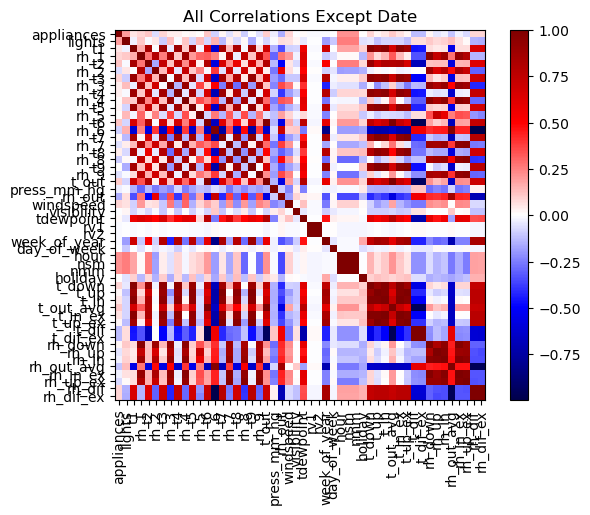

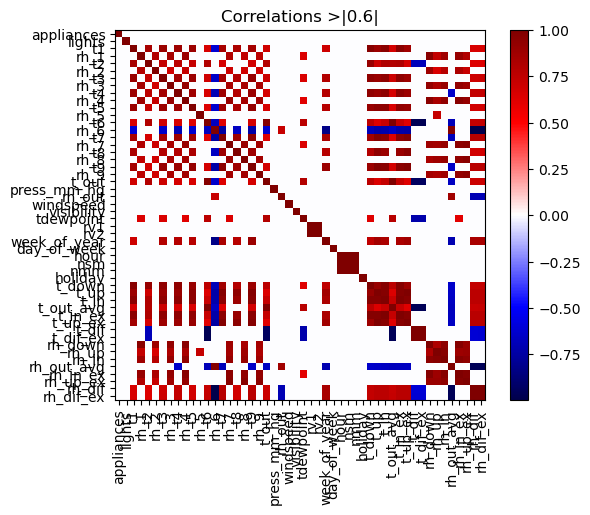

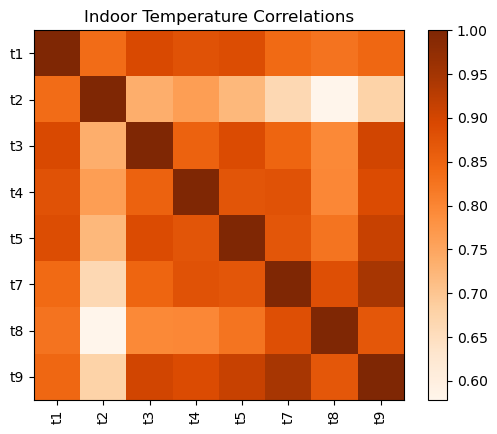

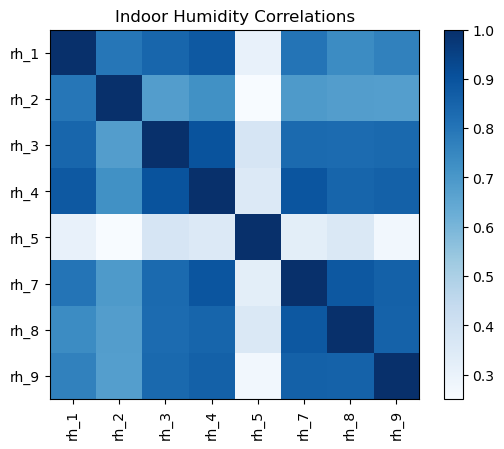

<Axes: title={'center': 'Correlations with Target Variable'}>

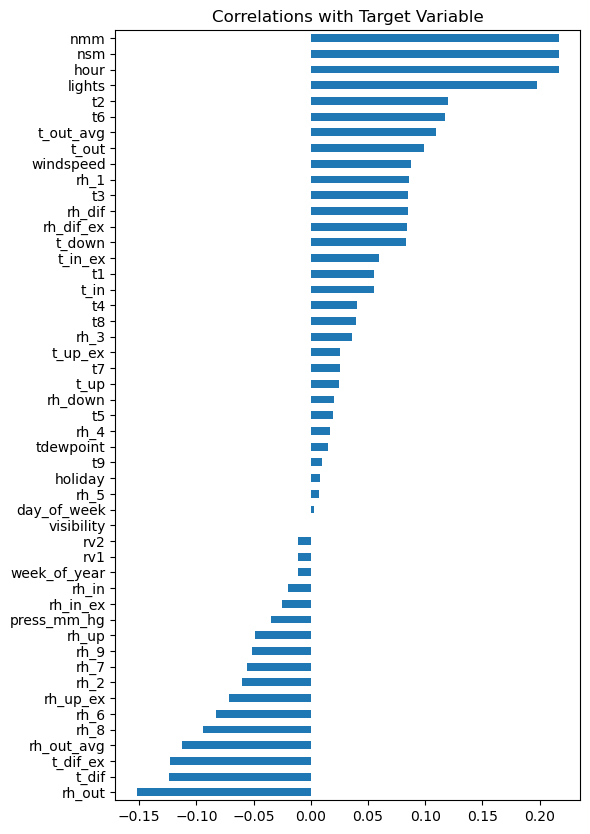

In [11]:
# CORRELATION

df_corr = df.corr(numeric_only = True)

plt.imshow(df_corr, cmap ="seismic")
plt.title("All Correlations Except Date")
plt.colorbar()
plt.xticks(range(len(df_corr)), df_corr.columns, rotation=90)
plt.yticks(range(len(df_corr)), df_corr.index)
plt.show()

# Only correlations over |0.6|
df_corr2 = pd.DataFrame(np.where(np.abs(df_corr) <0.6, 0, df_corr))

plt.imshow(df_corr2, cmap="seismic")
plt.title("Correlations >|0.6|")
plt.colorbar()
plt.xticks(range(len(df_corr)), df_corr.columns, rotation = 90)
plt.yticks(range(len(df_corr)), df_corr.index)
plt.show()

# Indoor Temperature Correlations
df_corr_temp = df[['t1', 't2', 't3', 't4', 't5', 't7', 't8', 't9']].corr()
plt.imshow(df_corr_temp, cmap = 'Oranges')
plt.title("Indoor Temperature Correlations")
plt.colorbar()
plt.xticks(range(len(df_corr_temp)), df_corr_temp.columns, rotation = 90)
plt.yticks(range(len(df_corr_temp)), df_corr_temp.index)
plt.show()

# Indoor Humidity Correlations
df_corr_hum = df[['rh_1', 'rh_2', 'rh_3', 'rh_4','rh_5', 'rh_7', 'rh_8', 'rh_9']].corr()
plt.imshow(df_corr_hum, cmap = 'Blues')
plt.title("Indoor Humidity Correlations")
plt.colorbar()
plt.xticks(range(len(df_corr_hum)), df_corr_hum.columns, rotation = 90)
plt.yticks(range(len(df_corr_hum)), df_corr_hum.index)
plt.show()

# Correlations with target variable
df_corr['appliances'][1:].sort_values().plot(kind = 'barh', title = 'Correlations with Target Variable', figsize=(6,10))

<Axes: title={'center': 'Mutual Information Scores with Target Variable'}>

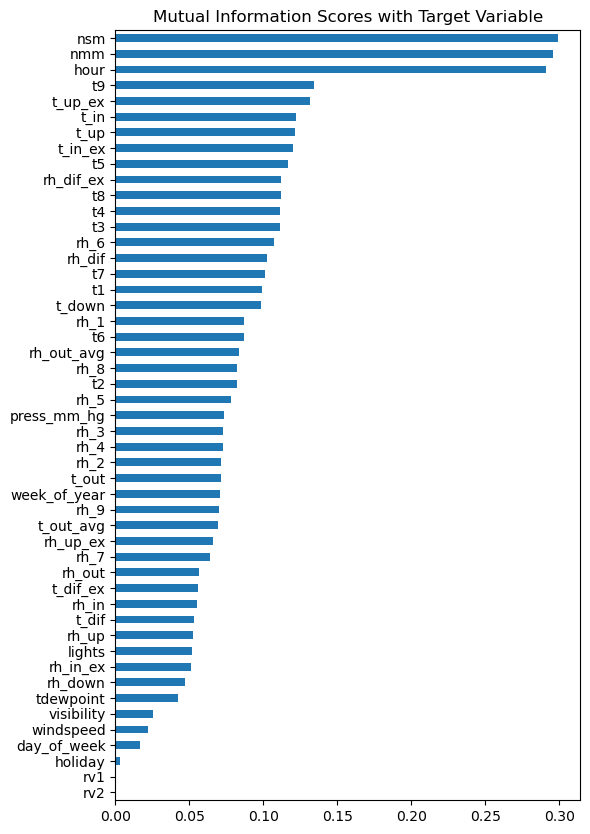

In [12]:
# MUTUAL INFORMATION

df_mi = pd.DataFrame(mutual_info_regression(df.loc[:,'lights'::1],df['appliances'], random_state=123))

df_mi.index = df.loc[:,'lights'::1].columns
df_mi.columns = ['mi_score']
df_mi = df_mi.sort_values(by = 'mi_score', ascending=True)

df_mi.plot.barh(figsize = (6,10), title = 'Mutual Information Scores with Target Variable', legend = False)

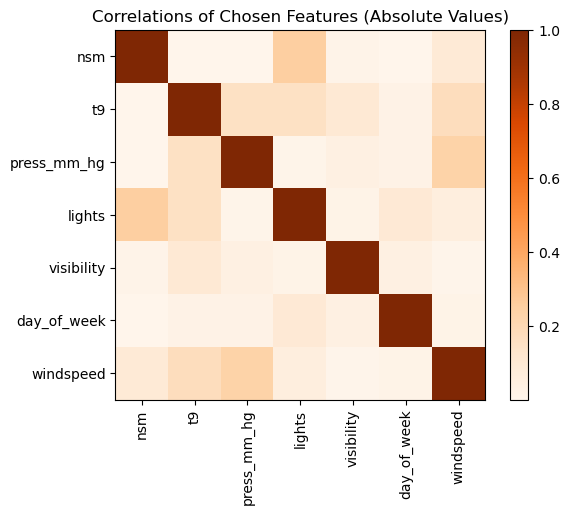

In [13]:
# FEATURE SELECTION

# Chosen features
features = ['nsm', 't9', 'press_mm_hg', 'lights', 'visibility', 'day_of_week', 'windspeed']

# Checking there's no multicollinearity in chosen features
df_corr_feat = np.abs(df[features].corr(numeric_only = True))

plt.imshow(df_corr_feat, cmap ="Oranges")
plt.title("Correlations of Chosen Features (Absolute Values)")
plt.colorbar()
plt.xticks(range(len(df_corr_feat)), df_corr_feat.columns, rotation=90)
plt.yticks(range(len(df_corr_feat)), df_corr_feat.index)
plt.show()

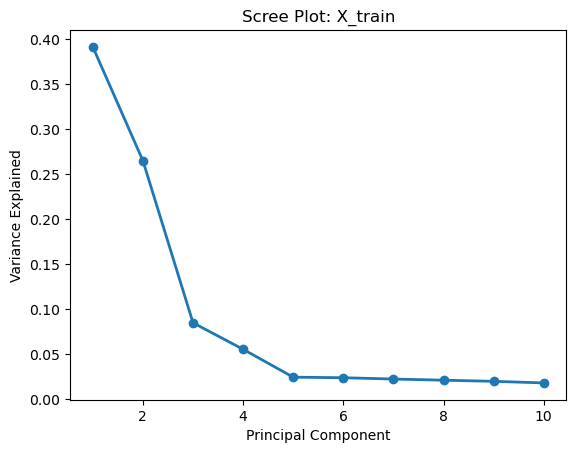

Variance explained by each component of 10 [0.39 0.27 0.08 0.06 0.02 0.02 0.02 0.02 0.02 0.02]
Variance explained by each component of 4 [0.39 0.27 0.08 0.06]
Variance explained by 4 components 0.8
x_train_pca has size (15788, 4)
x_test_pca has size (3947, 4)


Text(0.5, 1.0, 'X_train in Four Principal Components')

<Figure size 640x480 with 0 Axes>

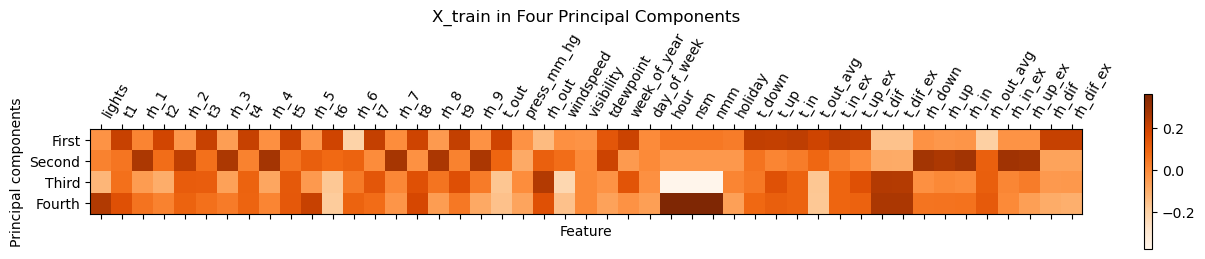

In [14]:
# MODEL PREPARATION

# Splitting test and train sets

df_train, df_test = train_test_split(df, train_size=0.8, random_state = 123)

#print(f'df_train has size {df_train.shape}')
#print(f'df_test has size {df_test.shape}')

#df_train.info()

# Cross Validation
# Setting here so that each model can use the same split.
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

x_train = df_train[features]
y_train = df_train['appliances']

x_test = df_test[features]
y_test = df_test['appliances']

# PCA sets - using whole dataset
x_train_pca = df_train.loc[:, ~df.columns.isin(['date', 'appliances', 'rv1', 'rv2'])] # Can't use datetime, rvs are random variables
x_test_pca = df_test.loc[:, ~df.columns.isin(['date', 'appliances', 'rv1', 'rv2'])]

cols = x_train_pca.columns

x_train_pca = StandardScaler().fit_transform(x_train_pca)
x_test_pca = StandardScaler().fit_transform(x_test_pca)

pca = PCA(n_components=10, random_state=123).fit(x_train_pca)

# Scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.figure()
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot: X_train')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print(f"Variance explained by each component of 10 {pca.explained_variance_ratio_.round(2)}")
#4 looks good

pca4 = PCA(n_components=4, random_state=123).fit(x_train_pca)
print(f"Variance explained by each component of 4 {pca4.explained_variance_ratio_.round(2)}")
print(f"Variance explained by 4 components {pca4.explained_variance_ratio_.sum().round(2)}")
# 4 gets 80% of the variance. Really, you'd want less components and more variance, so PCA may not work well.

x_train_pca = pca4.transform(x_train_pca)
x_test_pca = pca4.transform(x_test_pca)

print(f'x_train_pca has size {x_train_pca.shape}')
print(f'x_test_pca has size {x_test_pca.shape}')

plt.figure()
plt.matshow(pca4.components_, cmap='Oranges')
plt.yticks([0, 1, 2, 3], ['First', 'Second', 'Third', 'Fourth'])
plt.colorbar()
plt.xticks(range(len(cols)), cols, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')
plt.title('X_train in Four Principal Components')


In [20]:
# LINEAR REGRESSION

model_lin = LinearRegression().fit(x_train,y_train)

r2_train_lin = model_lin.score(x_train, y_train).round(2)
print('R2 TRAIN:', r2_train_lin)
print('intercept:', model_lin.intercept_.round(2))
print('slope:', model_lin.coef_.round(2))
pred = model_lin.predict(x_train).round(-1)
rmse_train_lin = mean_squared_error(y_true=y_train,y_pred=pred,squared=False).round(2)
print('RMSE train:', rmse_train_lin)


pred_lin = model_lin.predict(x_test).round(-1) # -1 round to nearest 10, as in dataset.
print('predicted response:', pred_lin, sep='\n')

# Model Eval

#plt.scatter(pred_lin, y_test)
#plt.show()

r2_test_lin = r2_score(y_test, pred_lin).round(2)
mae_lin = mean_absolute_error(y_true=y_test,y_pred=pred_lin).round(2)
mse_lin = mean_squared_error(y_true=y_test,y_pred=pred_lin).round(2)
rmse_test_lin = mean_squared_error(y_true=y_test,y_pred=pred_lin,squared=False).round(2)

print('R2 TEST:', r2_test_lin)
print("MAE:",mae_lin) 
print("MSE:",mse_lin) 
print("RMSE:",rmse_test_lin)

# Looking at the coefficients would be meaningless, since the data isn't scaled.

R2 TRAIN: 0.08
intercept: 76.89
slope: [ 0.    2.32 -0.11  2.09  0.09  0.92  2.74]
RMSE train: 98.76
predicted response:
[100.  70.  60. ...  50.  70. 140.]
R2 TEST: 0.07
MAE: 54.73
MSE: 9672.49
RMSE: 98.35


In [21]:
# LINEAR REGRESSION WITH PCA

model_lin = LinearRegression().fit(x_train_pca,y_train)

r2_train_lin_pca = model_lin.score(x_train_pca, y_train).round(2)
print('R2 TRAIN:', r2_train_lin_pca)
print('intercept:', model_lin.intercept_.round(2))
print('slope:', model_lin.coef_.round(2))
pred = model_lin.predict(x_train_pca).round(-1)
rmse_train_lin_pca = mean_squared_error(y_true=y_train,y_pred=pred,squared=False).round(2)
print('RMSE train:', rmse_train_lin_pca)

pred_lin = model_lin.predict(x_test_pca).round(-1) # -1 round to nearest 10, as in dataset.
print('predicted response:', pred_lin, sep='\n')

# Model Eval

#plt.scatter(pred_lin, y_test)
#plt.show()

r2_test_lin_pca = r2_score(y_test, pred_lin).round(2)
mae_lin_pca = mean_absolute_error(y_true=y_test,y_pred=pred_lin).round(2)
mse_lin_pca = mean_squared_error(y_true=y_test,y_pred=pred_lin).round(2)
rmse_test_lin_pca = mean_squared_error(y_true=y_test,y_pred=pred_lin,squared=False).round(2)

print('R2 TEST:', r2_test_lin_pca)
print("MAE:",mae_lin_pca) 
print("MSE:",mse_lin_pca) 
print("RMSE:",rmse_test_lin_pca)

# Hasn't helped.

R2 TRAIN: 0.07
intercept: 97.88
slope: [  1.96  -0.41 -11.54   6.36]
RMSE train: 99.16
predicted response:
[ 60.  70.  60. ...  50.  60. 130.]
R2 TEST: 0.07
MAE: 55.09
MSE: 9715.71
RMSE: 98.57


R2         0.77
MAE       15.19
MSE     2422.54
RMSE      49.22
dtype: float64
R2         0.40
MAE       36.84
MSE     6276.92
RMSE      79.23
dtype: float64


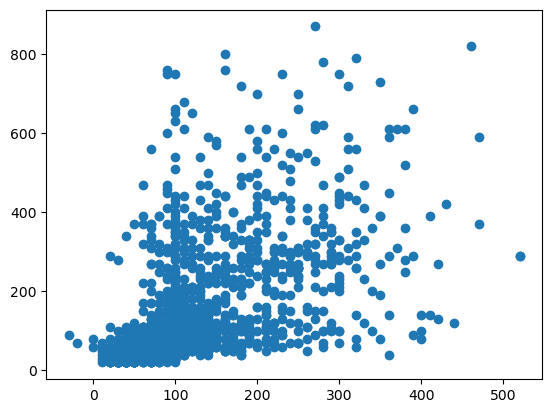

In [22]:
# SVM - RADIAL

x_test_rb = RobustScaler().fit_transform(x_test)

"""

pipe_svm = Pipeline(
  [
      ("scalar", RobustScaler()),
      ("estimator", SVR(kernel= 'rbf', epsilon=5, gamma=15, C=375)), 
  ],
  verbose=False,
)

# Grid Search

param_grid = dict(estimator__C = [375,400,425], estimator__gamma = [15,20,25])

#svm_gs = RandomizedSearchCV(pipe_svm, param_distributions = param_grid, n_iter = 20, scoring = 'r2', cv = cv).fit(x_train, y_train)
svm_gs = GridSearchCV(pipe_svm, param_grid = param_grid, scoring = 'r2', cv = cv).fit(x_train, y_train)

svm_gs_pred = svm_gs.predict(x_test_rb).round(-1)

print('Best Params:', svm_gs.best_params_)
print('Best R2 Score:', svm_gs.best_score_.round(2))

"""

x_train_rb = RobustScaler().fit_transform(x_train)

svm = SVR(kernel= 'rbf', epsilon=5, gamma=15, C=375).fit(x_train_rb, y_train)

svm_train_pred = svm.predict(x_train_rb).round(-1) # Round to nearest 10

svm_train_scores = pd.Series({
                'R2': r2_score(y_train, svm_train_pred).round(2),
                'MAE': mean_absolute_error(y_train, svm_train_pred).round(2),
                'MSE': mean_squared_error(y_train, svm_train_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_train, svm_train_pred)),2)
                             })
print(svm_train_scores)

svm_pred = svm.predict(x_test_rb).round(-1) 

svm_scores = pd.Series({
                'R2': r2_score(y_test, svm_pred).round(2),
                'MAE': mean_absolute_error(y_test, svm_pred).round(2),
                'MSE': mean_squared_error(y_test, svm_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_test, svm_pred)),2)
                             })
print(svm_scores)

plt.scatter(svm_pred, y_test)
plt.show()


SVR TUNING

C [0.1,1,10,100], gamma [0.1,1,10,100], epsilon [0.1,1,10,100] => gamma 10, epsi 1, C 100 (0.33)
C [100,200,300], gamma [5,25,45], epsilon [0.5,3,5] => gamma 25, epsilon 5, C 300
C [300,400,500], gamma [15,25,35], epsilon [4,5] => gamma 15, epsilon 5, C 400 (0.38)
epsi 5, C [375,400,425], gamma [15,20,25] => gamma 15, C 375 (0.38)

R2         0.88
MAE       11.05
MSE     1300.83
RMSE      36.07
dtype: float64
R2         0.49
MAE       33.11
MSE     5282.14
RMSE      72.68
dtype: float64


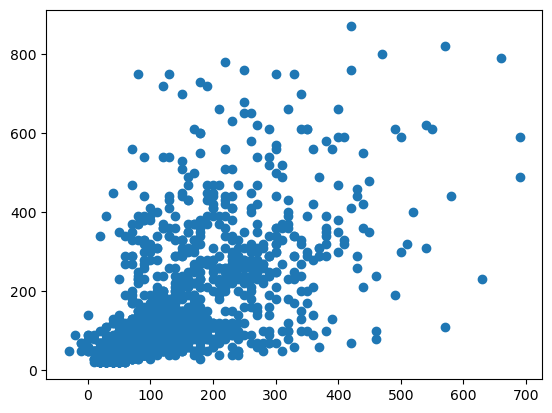

In [23]:
# SVM RADIAL - PCA

"""

pca_grid = {'C' : [600,625,650,675, 700], 'gamma' : [5,6,7]}

svm_gs_pca = GridSearchCV(SVR(kernel='rbf', epsilon=5), param_grid = pca_grid, scoring = 'r2', cv = cv).fit(x_train_pca, y_train)

print('Best Params:', svm_gs_pca.best_params_)
print('Best R2 Score:', svm_gs_pca.best_score_)

"""

# Final Model

svm_pca = SVR(kernel= 'rbf', epsilon=5, gamma=5, C=650).fit(x_train_pca, y_train)

svm_pca_train_pred = svm_pca.predict(x_train_pca).round(-1) # Round to nearest 10

svm_pca_train_scores = pd.Series({
                'R2': r2_score(y_train, svm_pca_train_pred).round(2),
                'MAE': mean_absolute_error(y_train, svm_pca_train_pred).round(2),
                'MSE': mean_squared_error(y_train, svm_pca_train_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_train, svm_pca_train_pred)),2)
                             })
print(svm_pca_train_scores)

svm_pca_pred = svm_pca.predict(x_test_pca).round(-1)

svm_pca_scores = pd.Series({
                'R2': r2_score(y_test, svm_pca_pred).round(2),
                'MAE': mean_absolute_error(y_test, svm_pca_pred).round(2),
                'MSE': mean_squared_error(y_test, svm_pca_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_test, svm_pca_pred)),2)
                             })
print(svm_pca_scores)

plt.scatter(svm_pca_pred, y_test)
plt.show()

SVM PCA TUNING
Start from prior parameters.
'C' : [350,375,400], 'gamma' : [10,15,20], 'epsilon' : [3,5,7] => C 400, ep 5 gamma 10
'C' : [400,450,500,550], 'gamma' : [5,10,15] => C 550 Gamma 5
'C' : [550,650,750], 'gamma' : [2,4,6] => C 650 gamma 6
'C' : [600,625,650,675, 700], 'gamma' : [5,6,7] => C 650, gamma 5

[ 60.  50.  50. ...  60.  50. 110.]


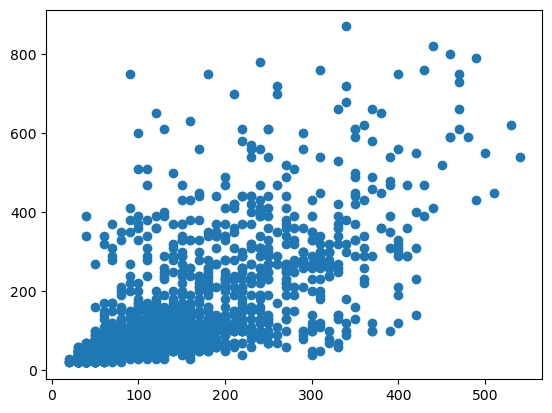

R2         0.55
MAE       32.19
MSE     4634.10
RMSE      68.07
dtype: float64


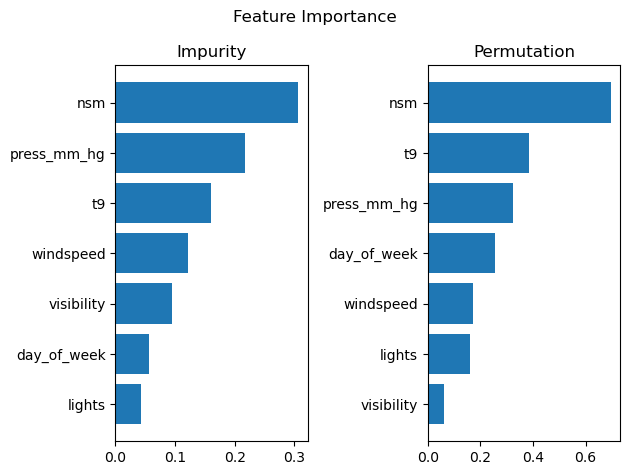

In [24]:
# RANDOM FOREST - BASIC
# Random forests don't need separate cross-validation or scaling

rf_model = RandomForestRegressor(n_jobs = -1, random_state=123).fit(x_train, y_train)

rf_train_pred = rf_model.predict(x_train).round(-1)

rf_train_scores = pd.Series({
                'R2': r2_score(y_train, rf_train_pred).round(2),
                'MAE': mean_absolute_error(y_train, rf_train_pred).round(2),
                'MSE': mean_squared_error(y_train, rf_train_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_train, rf_train_pred)),2)
                             })

rf_pred = rf_model.predict(x_test).round(-1)
print(rf_pred)

rf_scores = pd.Series({
                'R2': r2_score(y_test, rf_pred).round(2),
                'MAE': mean_absolute_error(y_test, rf_pred).round(2),
                'MSE': mean_squared_error(y_test, rf_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_test, rf_pred)),2)
                             })

plt.scatter(rf_pred, y_test)
plt.show()

print(rf_scores)

# Feature Importance - Impurity
feat_importances = pd.Series(rf_model.feature_importances_, index=x_train.columns).sort_values(ascending = True)

# Feature Importance - Permutation
result = permutation_importance(
    rf_model, x_test, y_test, n_repeats=10, random_state=123, n_jobs=2
)
pm_importances = pd.Series(result.importances_mean, index=x_train.columns).sort_values(ascending = True)

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Feature Importance')
ax1.barh(feat_importances.index, feat_importances.values)
ax1.set_title('Impurity')
ax2.barh(pm_importances.index, pm_importances.values)
ax2.set_title('Permutation')
plt.tight_layout()
plt.show()

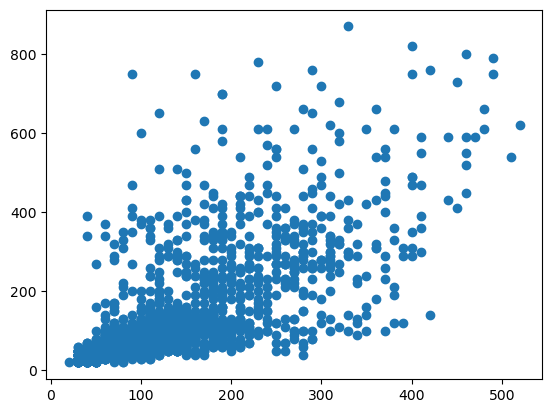

R2        0.94
MAE      10.80
MSE     602.82
RMSE     24.55
dtype: float64 R2         0.57
MAE       31.25
MSE     4490.22
RMSE      67.01
dtype: float64


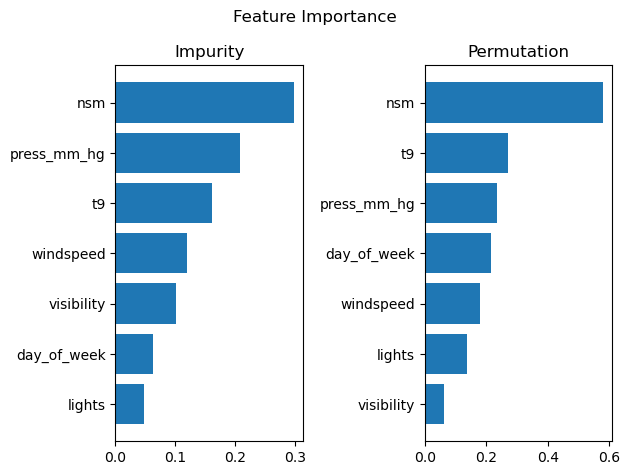

In [25]:
# RANDOM FOREST - TUNED

# Basic model has much higher r2 train than r2 test, so it's overfitted.
"""
# Default estimators is 100, max features is sqrt (3)
param_grid = {'n_estimators':[675,700,725,750]}

rf_grid = GridSearchCV(RandomForestRegressor(n_jobs = -1, random_state=123, n_estimators=750, max_depth=33, max_features=3), 
                        param_grid, scoring='r2', cv=cv).fit(x_train, y_train)

print(rf_grid.best_estimator_)
print(f'Best r2: ', rf_grid.best_score_.round(2))

"""
# Final Model

rf_model2 = RandomForestRegressor(n_estimators = 750, max_depth=33, max_features=3, n_jobs = -1, random_state=123).fit(x_train, y_train)

rf_train_pred2 = rf_model2.predict(x_train).round(-1)

rf_train_scores2 = pd.Series({
                'R2': r2_score(y_train, rf_train_pred2).round(2),
                'MAE': mean_absolute_error(y_train, rf_train_pred2).round(2),
                'MSE': mean_squared_error(y_train, rf_train_pred2).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_train, rf_train_pred2)),2)
                             })

rf_pred2 = rf_model2.predict(x_test).round(-1)

rf_scores2 = pd.Series({
                'R2': r2_score(y_test, rf_pred2).round(2),
                'MAE': mean_absolute_error(y_test, rf_pred2).round(2),
                'MSE': mean_squared_error(y_test, rf_pred2).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_test, rf_pred2)),2)
                             })

plt.scatter(rf_pred2, y_test)
plt.show()

print(rf_train_scores2,rf_scores2)

# Feature Importance - Impurity
feat_imp_rf = pd.Series(rf_model2.feature_importances_, index=x_train.columns).sort_values(ascending = True)

# Feature Importance - Permutation
result2 = permutation_importance(
    rf_model2, x_test, y_test, n_repeats=10, random_state=123, n_jobs=2
)
feat_pm_rf = pd.Series(result2.importances_mean, index=x_train.columns).sort_values(ascending = True)

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Feature Importance')
ax1.barh(feat_imp_rf.index, feat_imp_rf.values)
ax1.set_title('Impurity')
ax2.barh(feat_pm_rf.index, feat_pm_rf.values)
ax2.set_title('Permutation')
plt.tight_layout()
plt.show()

RF Tuning
Start with default estimators (100)
'max_depth': [5,10,15], 'min_samples_split': [100,500,1000] => MD 15 MSS 100
MD [15,20,25], MSS [50,75,100] => MD 25, MSS 50, MD [25,30,35] MSS [20,40,60] => MD 35, MSS 20, MD [35,45,55] MSS [5,10,20] => MD 35, MSS 5, MD [33,35,37,39] MSS [2,4,6] => MD 33, MSS 2 (default), MD 33 MSS [1,2,3] => MSS 2
'min_samples_leaf': [1,2,3,4,5] => 1 (default)
'max_features':[2,3,4,5] => 3
'max_samples':[0.25,0.5,0.75,1.0] => 1.0 (default)

Back to n_estimators:
NE [100,500,1000] => 500, [250,400,600,750] => 750, [675,700,725,750] => 750

[ 60.  40.  50. ...  60.  60. 140.]


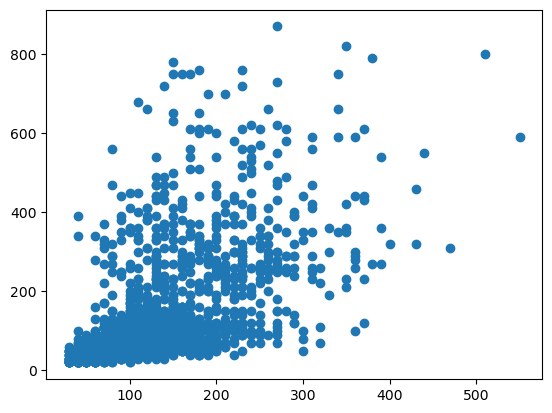

R2        0.93
MAE      13.29
MSE     784.34
RMSE     28.01
dtype: float64 R2         0.43
MAE       38.74
MSE     5950.34
RMSE      77.14
dtype: float64


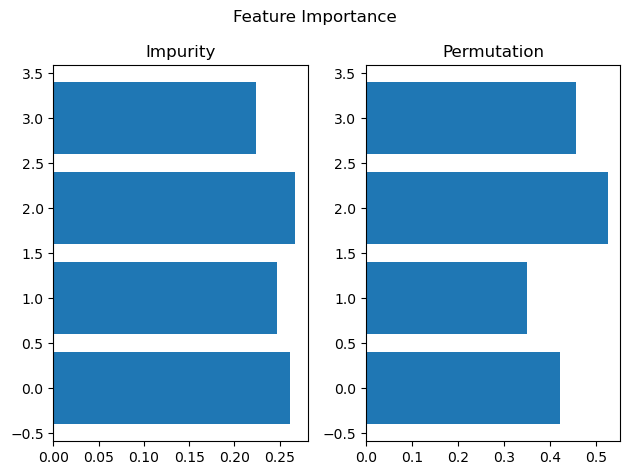

In [26]:
# RANDOM FOREST - PCA

"""

param_grid_pca = {'n_estimators': [800,825,850]}

rf_grid_pca = GridSearchCV(RandomForestRegressor(n_jobs = -1, random_state=123, max_depth=39, max_features=2), 
                        param_grid_pca, scoring='r2', cv=cv).fit(x_train_pca, y_train)

print(rf_grid_pca.best_estimator_)
print(f'Best r2: ', rf_grid_pca.best_score_.round(2))

"""
#Final Model

rf_pca = RandomForestRegressor(n_jobs = -1, random_state=123, n_estimators=800, max_depth=39, max_features=2).fit(x_train_pca, y_train)

rf_pca_train_pred = rf_pca.predict(x_train_pca).round(-1)

rf_train_scores_pca = pd.Series({
                'R2': r2_score(y_train, rf_pca_train_pred).round(2),
                'MAE': mean_absolute_error(y_train, rf_pca_train_pred).round(2),
                'MSE': mean_squared_error(y_train, rf_pca_train_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_train, rf_pca_train_pred)),2)
                             })

rf_pca_pred = rf_pca.predict(x_test_pca).round(-1)
print(rf_pca_pred)

rf_scores_pca = pd.Series({
                'R2': r2_score(y_test, rf_pca_pred).round(2),
                'MAE': mean_absolute_error(y_test, rf_pca_pred).round(2),
                'MSE': mean_squared_error(y_test, rf_pca_pred).round(2),
                'RMSE': round(sqrt(mean_squared_error(y_test, rf_pca_pred)),2)
                             })

plt.scatter(rf_pca_pred, y_test)
plt.show()

print(rf_train_scores_pca, rf_scores_pca)

# Feature Importance - Impurity
feat_importances = pd.Series(rf_pca.feature_importances_).sort_values(ascending = True)

# Feature Importance - Permutation
result = permutation_importance(
    rf_pca, x_test_pca, y_test, n_repeats=10, random_state=123, n_jobs=2
)
pm_importances = pd.Series(result.importances_mean).sort_values(ascending = True)

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Feature Importance')
ax1.barh(feat_importances.index, feat_importances.values)
ax1.set_title('Impurity')
ax2.barh(pm_importances.index, pm_importances.values)
ax2.set_title('Permutation')
plt.tight_layout()
plt.show()


RF PCA Tuning
Start with default estimators (100). Start with values similar to those in original RF model.
'max_depth': [20,30,40], 'min_samples_split': [1,5,10] => MD 40 MSS 5, MD [35,45,55], MSS [3,5,7] => MD 35 MSS 3, MD [35,37,39], MSS [2,3,4] => MD 39 MSS default
'min_samples_leaf': [1,2,3,4,5] => default
'max_features':[2,3,4,5] => 2
'max_samples':[0.25,0.5,0.75,1.0] => default
'n_estimators': [200,400,600,800] => 800, [700,900,1100,1300] => 900, [800,850,900,950,1000] => 800, [800,825,850] => 800

Train scores:  0.9977772313376435 23.42285279959463 1.6987585507980745 4.839716189984143
The r2 on test set: 0.5567
The mean squared error (MSE) on test set: 4611.4264
The mean absolute error (MAE) on test set: 33.1416
The root mean squared error (RMSE) on test set: 67.9075


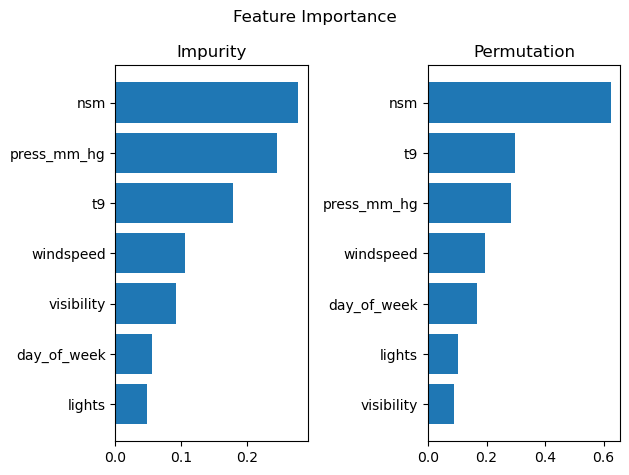

In [27]:
# GRADIENT BOOSTER
# Doesn't need scaling

"""
# Parameter tuning - details below.

param_grid = {'n_estimators' : [690,700,710]}

gbr_grid = GridSearchCV(GradientBoostingRegressor(learning_rate = 0.05, 
                          max_depth = 30, min_samples_split = 60, max_features = 3, 
                          random_state=123), 
                        param_grid = param_grid,
                        scoring = 'r2',
                        cv=cv)

gbr_gs = gbr_grid.fit(x_train, y_train).round(-1)

print('Best parameters:', gbr_gs.best_params_)
print('Best train R2 Score:', gbr_gs.best_score_.round(2))

"""
# Final model
gbr = GradientBoostingRegressor(n_estimators = 700, learning_rate = 0.05, max_depth = 30, 
            min_samples_split = 60, max_features = 3, random_state = 123).fit(x_train, y_train)

train_pred = gbr.predict(x_train).round(-1)

# Train scores
gbr_r2_train = r2_score(y_train, train_pred)
gbr_mse_train = mean_squared_error(y_train, train_pred)
gbr_mae_train = mean_absolute_error(y_train, train_pred)
gbr_rmse_train = sqrt(mean_squared_error(y_train, train_pred))
print('Train scores: ', gbr_r2_train, gbr_mse_train, gbr_mae_train,gbr_rmse_train)

test_pred = gbr.predict(x_test).round(-1)
                      
# Test scores
gbr_r2 = r2_score(y_test, test_pred)
print("The r2 on test set: {:.4f}".format(gbr_r2))

gbr_mse = mean_squared_error(y_test, test_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(gbr_mse))

gbr_mae = mean_absolute_error(y_test, test_pred)
print("The mean absolute error (MAE) on test set: {:.4f}".format(gbr_mae))

gbr_rmse = sqrt(mean_squared_error(y_test, test_pred))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(gbr_rmse))

# Feature Importance - Impurity
feat_imp_gbr = pd.Series(gbr.feature_importances_, index=x_train.columns).sort_values(ascending = True)

# Feature Importance - Permutation
result = permutation_importance(
    gbr, x_test, y_test, n_repeats=10, random_state=123, n_jobs=2
)
feat_pm_gbr = pd.Series(result.importances_mean, index=x_train.columns).sort_values(ascending = True)

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Feature Importance')
ax1.barh(feat_imp_gbr.index, feat_imp_gbr.values)
ax1.set_title('Impurity')
ax2.barh(feat_pm_gbr.index, feat_pm_gbr.values)
ax2.set_title('Permutation')
plt.tight_layout()
plt.show()

Baseline R2 test 0.2592 both, MSE 7705 and 8859 pca
Following tuning order advice from https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/#h-parameter-tuning-with-example

Set LR 0.1, NE [20,30,40,50,60,70,80] => NE 80
LR 0.1, NE 80, 'max_depth': [5,10,15], 'min_samples_split': [100,500,1000] => MD 15 MSS 100 R2 train 0.47
'max_depth': [15,20,25],'min_samples_split': [50,100,150] => MD 25, MSS 50 R2 train 0.51
'max_depth': [25,30,35], 'min_samples_split': [20,40,60] => MD 30 MSS 60 R2 train 0.51
'max_depth': [25,30,35], 'min_samples_split': [60,70,80] => MD 30 MSS 60 R2 train 0.51

Got to R2 test 0.5354, MSE 4833. Tune further.

'min_samples_leaf':[0.1,0.25,0.5,0.75,1.0] => 0.1, r2 0.23
'min_samples_leaf':[1,2,3,4,5] => 1, r2 0.51 which is default
'max_features':(0.1,0.25,0.5,0.75,1.0) => 0.5, r2 0.53 - 7 features, so 0.5 is 3.5
'max_features':[2,3,4,5] => 3 r2 0.53
'subsample':[0.6,0.7,0.8,0.9] => 0.9, r2 0.52 #r2 gone down a bit, so try more specific values.
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1.0] => 1.0, r2 0.53 # 1 is the default

Now R2 test 0.5360 NSE 4827 tiny improvement. Try reducing learning rate, increase estimators.
LR 0.05, NE 160 => 0.5345, 4843 worse try 180 trees
LR 0.05, NE 180 => 0.5390, 4795 better
LR 0.05 NE [160,180,200,220] => 220, NE [250,300,350,400] => 400, NE [500,600,700,800] => 700, NE [650,700,750] => 700,
    NE [675,700,725] => 700, NE [690,700,710] => 700

Train scores:  1.0 0.0 0.0 0.0
The r2 on test set: 0.3631
The mean squared error (MSE) on test set: 6625.1077
The mean absolute error (MAE) on test set: 43.4685
The root mean squared error (RMSE) on test set: 81.3948


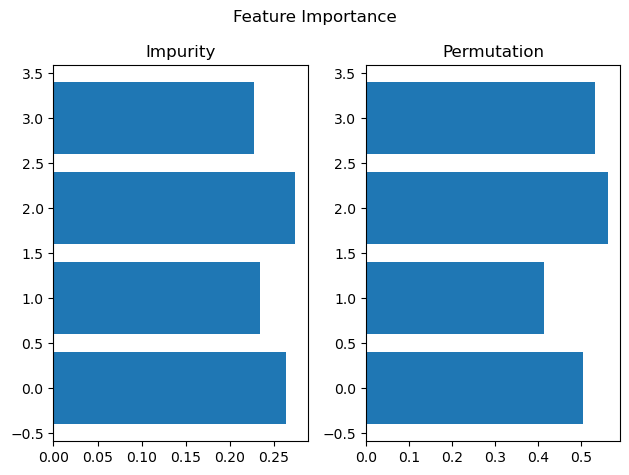

In [28]:
# GRADIENT BOOSTER - PCA

# Parameter tuning - details below.
"""
param_grid = {'n_estimators':[2600,2650,2700,2750,2800,2850]}

gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=123, learning_rate = 0.2,
                          max_depth = 22, min_samples_split = 17, min_samples_leaf = 3, max_features = 1), 
                        param_grid = param_grid,
                        scoring = 'r2',
                        cv=cv)

gbr_gs = gbr_grid.fit(x_train_pca, y_train).round(-1)

print('Best parameters:', gbr_gs.best_params_)
print('Best train R2 Score:', gbr_gs.best_score_)

"""
# Final Model

gbr_pca = GradientBoostingRegressor(random_state=123, learning_rate = 0.2, n_estimators = 2700, max_depth = 22, 
                                    min_samples_split = 17, min_samples_leaf = 3, max_features = 1).fit(x_train_pca, y_train) 

train_pred = gbr_pca.predict(x_train_pca).round(-1)
# Train scores
gbr_pca_r2_train = r2_score(y_train, train_pred)
gbr_pca_mse_train = mean_squared_error(y_train, train_pred)
gbr_pca_mae_train = mean_absolute_error(y_train, train_pred)
gbr_pca_rmse_train = sqrt(mean_squared_error(y_train, train_pred))
print("Train scores: ", gbr_pca_r2_train, gbr_pca_mse_train, gbr_pca_mae_train, gbr_pca_rmse_train)

test_pred = gbr_pca.predict(x_test_pca).round(-1)
# Test scores
gbr_pca_r2 = r2_score(y_test, test_pred)
print("The r2 on test set: {:.4f}".format(gbr_pca_r2))

gbr_pca_mse = mean_squared_error(y_test, test_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(gbr_pca_mse))

gbr_pca_mae = mean_absolute_error(y_test, test_pred)
print("The mean absolute error (MAE) on test set: {:.4f}".format(gbr_pca_mae))

gbr_pca_rmse = sqrt(mean_squared_error(y_test, test_pred))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(gbr_pca_rmse))

# Feature Importance - Impurity
feat_importances = pd.Series(gbr_pca.feature_importances_).sort_values(ascending = True)

# Feature Importance - Permutation
result = permutation_importance(
    gbr_pca, x_test_pca, y_test, n_repeats=10, random_state=123, n_jobs=2
)
pm_importances = pd.Series(result.importances_mean).sort_values(ascending = True)

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Feature Importance')
ax1.barh(feat_importances.index, feat_importances.values)
ax1.set_title('Impurity')
ax2.barh(pm_importances.index, pm_importances.values)
ax2.set_title('Permutation')
plt.tight_layout()
plt.show()

Parameter Tuning - GBR with PCA

LR 0.1, NE [60,70,80,90,100] => 100 # Too high, try higher learning rate. LR 0.2, NE [60,70,80,90,100] => 100
LR 0.3, NE [60,70,80,90,100] => 90
'max_depth': [5,10,15], 'min_samples_split': [100,500,1000] => MD 15 MSS 100
MD [15,20,25], MSS [50,100,150] => MD 20, MSS 50 / MD [18,20,22] MSS [10,30,50] => MD 22 MSS 10
MD 22, MSS [4,6,8] => 8, MSS [8,9,10] => 10, MSS [15,20,25] => 15, [11,13,15,17] => 17 #Not the most efficient, misread it.

'min_samples_leaf':[0.1,0.25,0.5,0.75,1.0] => 0.1, [1,2,3,4] => 3
'max_features':[2,3,4,5] => 1
'subsample':[0.6,0.7,0.8,0.9] => 0.9, [0.9,1.0] => 1 default, R2 0.358

LR 0.2, 'n_estimators':[500,700,900,1100] => 1100, [1500,2000,3000] => 3000, [5000,7500,10000] => 5000
[3000,3500,4000,4500,5000,5500,6000] => 3000, [2500,2750,3000,3250] => 2750, [2600,2650,2700,2750,2800,2850] => 2700

Default parameters gave r2 -0.8210, MSE 18944

LR 0.1, NE [40,60,80,100] => 40 (0.44), [25,30,35,40,45] => 45 (0.45)
LR 0.05 NE [100,200,300,400,500,600] => 400 (0.45) No improvement

LR 0.1, NE = 50, max_depth = 3 => MSE = 10641  default values
max_depth = 1 => no better
LR 0.9 ne=50, md=1 => 13768
lr 0.9, ne 50, md 2 => 13768
LR 0.1, ne=50, md 2 => 10641
LR 0.1 NE 50 MD 4 => 10641

In [29]:
# RESULTS TABLE

results = {'Regression Model':['Linear','Linear - PCA','SVM Radial', 'SVM Radial - PCA','RF', 'RF - PCA', 'GBM', 'GBM - PCA'],
          'R2 TRAIN':[r2_train_lin, r2_train_lin_pca,  svm_train_scores.loc['R2'], svm_pca_train_scores.loc['R2'], rf_train_scores2.loc['R2'],rf_train_scores_pca.loc['R2'], gbr_r2_train, gbr_pca_r2_train],
          'RMSE TRAIN':[rmse_train_lin, rmse_train_lin_pca, svm_train_scores.loc['RMSE'], svm_pca_train_scores.loc['RMSE'], rf_train_scores2.loc['RMSE'], rf_train_scores_pca.loc['RMSE'],gbr_rmse_train, 0],
          'R2 TEST':[r2_test_lin, r2_test_lin_pca, svm_scores.loc['R2'], svm_pca_scores.loc['R2'], rf_scores2.loc['R2'], rf_scores_pca.loc['R2'], gbr_r2, gbr_pca_r2],
          'RMSE TEST':[rmse_test_lin, rmse_test_lin_pca, svm_scores.loc['RMSE'], svm_pca_scores.loc['RMSE'], rf_scores2.loc['RMSE'],rf_scores_pca.loc['RMSE'], gbr_rmse, gbr_pca_rmse]}

# gbr_pca_rmse_train is so small it throws the rest of the numbers off, so zero is used instead.

df_results = pd.DataFrame(results)

df_results[['R2 TRAIN','RMSE TRAIN', 'R2 TEST', 'RMSE TEST']] = df_results[['R2 TRAIN','RMSE TRAIN', 'R2 TEST', 'RMSE TEST']].map("{:.2f}".format)

df_results

,Regression Model,R2 TRAIN,RMSE TRAIN,R2 TEST,RMSE TEST
0,Linear,0.08,98.76,0.07,98.35
1,Linear - PCA,0.07,99.16,0.07,98.57
2,SVM Radial,0.77,49.22,0.40,79.23
3,SVM Radial - PCA,0.88,36.07,0.49,72.68
4,RF,0.94,24.55,0.57,67.01
5,RF - PCA,0.93,28.01,0.43,77.14
6,GBM,1.00,4.84,0.56,67.91
7,GBM - PCA,1.00,0.00,0.36,81.39


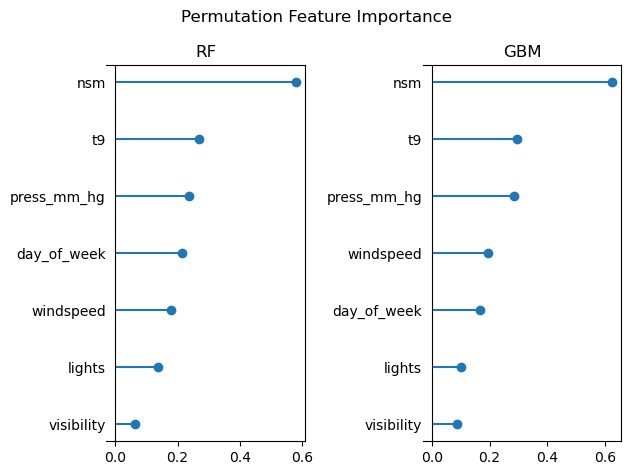

In [30]:
# Feature Importance Comparison
# Using PFI

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Permutation Feature Importance')
ax1.stem(feat_pm_rf.index, feat_pm_rf.values, orientation='horizontal', basefmt='white')
ax1.tick_params(axis='y', color='white')
ax1.spines['left'].set_position('zero') #To make the axes cross at zero.
ax1.set_title('RF')
ax2.stem(feat_pm_gbr.index, feat_pm_gbr.values, orientation='horizontal', basefmt='white')
ax2.tick_params(axis='y', color='white')
ax2.spines['left'].set_position('zero')
ax2.set_title('GBM')
plt.tight_layout()
plt.show()

# Pretty much the same for both models.

In [31]:
# COMPARISON WITH ORIGINAL PAPER

org_results = pd.DataFrame({'Regression Model':['Linear - Org','SVM Radial - Org','RF - Org', 'GBM - Org'],
          'R2 TRAIN':[0.18,0.85,0.92,0.97],
          'RMSE TRAIN':[93.21,39.35,29.61,17.56],
          'R2 TEST':[0.16,0.52,0.54,0.57],
          'RMSE TEST':[93.18,70.74,68.48,66.65]})

total_results = pd.concat([df_results, org_results], ignore_index=True).sort_values(by='Regression Model') #ignore_index reorders the indices

total_results

,Regression Model,R2 TRAIN,RMSE TRAIN,R2 TEST,RMSE TEST
6,GBM,1.00,4.84,0.56,67.91
11,GBM - Org,0.97,17.56,0.57,66.65
7,GBM - PCA,1.00,0.00,0.36,81.39
0,Linear,0.08,98.76,0.07,98.35
8,Linear - Org,0.18,93.21,0.16,93.18
1,Linear - PCA,0.07,99.16,0.07,98.57
4,RF,0.94,24.55,0.57,67.01
10,RF - Org,0.92,29.61,0.54,68.48
5,RF - PCA,0.93,28.01,0.43,77.14
2,SVM Radial,0.77,49.22,0.40,79.23


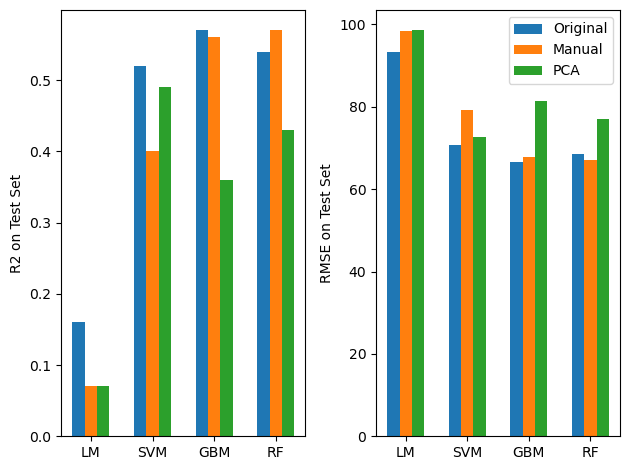

In [32]:
# Model Comparison Graphs

width = 0.2

plt.subplot(1, 2, 1)
x = np.arange(4)
y1 = np.array(total_results.loc[[8,9,11,10],'R2 TEST']) # Original values
y2 = np.array(total_results.loc[[0,2,6,4], 'R2 TEST']).astype(float)  # Manually selected
y3 = np.array(total_results.loc[[1,3,7,5], 'R2 TEST']).astype(float)  # PCA selected

#print(x,y1,y2,y3)

plt.bar(x-0.2, y1, width)
plt.bar(x, y2, width)
plt.bar(x+0.2, y3, width)
plt.xticks(x, ['LM', 'SVM', 'GBM', 'RF'])
plt.ylabel('R2 on Test Set')

plt.subplot(1, 2, 2)
y4 = np.array(total_results.loc[[8,9,11,10],'RMSE TEST']) # Original values
y5 = np.array(total_results.loc[[0,2,6,4], 'RMSE TEST']).astype(float)  # Manually selected
y6 = np.array(total_results.loc[[1,3,7,5], 'RMSE TEST']).astype(float)  # PCA selected
plt.bar(x-0.2, y4, width)
plt.bar(x, y5, width)
plt.bar(x+0.2, y6, width)
plt.xticks(x, ['LM', 'SVM', 'GBM', 'RF'])
plt.ylabel('RMSE on Test Set')
plt.legend(['Original', 'Manual', 'PCA'])

plt.tight_layout()
plt.show()
